In [1]:
import time
import math
import pandas as pd
import numpy as np
import requests
import json
import multiprocess
from multiprocess import Pool
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.preprocessing import PowerTransformer

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

from uniswap import get_input_price, get_output_price, buy_to_price
from graph_util import fetch_safes, fetch_rp, fetch_debt_ceiling
from util import chunks

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

## Overview

Explore how system liquidation_ratios affect how much bad debt is created during ETH/USD price dops.

## Methodology

Simulate an ETH/USD price drop of X%, then use RAI from Uniswap pools to settle resulting collateral auctions. 

## Simulations

1) Using mainnet collateral amounts and c-ratios

2) Use mainnet collateral amounts and stochastic c-ratios

3) Use stochastic collateral amounts and stochastic c-ratios


## Pessimistic Assumptions
### - All RAI for collateral auctions will come from pools. No RAI-holding keepers bid on auctions
### - No opposing market forces to push market back towards redemption price when keepers purchase RAI
### - RAI maintains market_price = redemption_price on eth shock
### - Saviours not considered


## Optimistic Assumptions
### - *Pool liquidity is not reduced during ETH shock*
### - Gas price is not considered
### - Surplus buffer not considered, so no surplus auctions,

Fetch ETH/USD price, redemption price and all Reflexer SAFEs

In [3]:
#graphql_url = 'https://subgraph.reflexer.finance/subgraphs/name/reflexer-labs/rai'
graphql_url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'
eth_usd_url = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd'
ETH_USD = requests.get(eth_usd_url).json()['ethereum']['usd']
REDEMPTION_PRICE = fetch_rp(graphql_url)
DEBT_CEILING = fetch_debt_ceiling(graphql_url)
orig_safes = fetch_safes(graphql_url)

# only consider SAFEs with debt
orig_safes = orig_safes.query('debt > 0').reset_index()

In [4]:
### Consider Debt Ceiling. (Not currently used)

In [5]:
sys_cratio = (orig_safes['collateral'].sum() * ETH_USD) / (orig_safes['debt'].sum() * REDEMPTION_PRICE)

# Extra debt and collateral that can be created if debt ceiling is exhausted(use system c-ratio)
extra_debt = DEBT_CEILING  - orig_safes['debt'].sum()
#extra_collateral = (extra_debt * REDEMPTION_PRICE) * sys_cratio / ETH_USD

## Mainnet Parameters

In [6]:
MAINNET_LIQ_RATIO = 1.40 
LIQ_PENALTY = 1.10
INITIAL_SURPLUS = 493000
MIN_DISCOUNT = 0.92
MAX_DISCOUNT = 0.90


# use max_discount for collateral_auctions
DISCOUNT = MAX_DISCOUNT
OSM_RESPONSIVENESS = 0.35 # What percent of SAFE owners avoid liquidation with OSM delay

# RAI pools
RAI_ETH_V2= 7.04E6
RAI_ETH_V3 = 58E3 
RAI_DAI_V3 = 3.58E6 
RAI_USDC_V3 = 1.11E6 

rai_v2_pool = RAI_ETH_V2 + RAI_ETH_V3
usd_v2_pool = rai_v2_pool * REDEMPTION_PRICE
rai_v3_pool = RAI_DAI_V3 + RAI_USDC_V3
usd_v3_pool = rai_v3_pool * REDEMPTION_PRICE

SURPLUS_BUFFER = 500000 # Not currently used
DISCOUNT_UPDATE_RATE = Decimal(0.999991859697312485818842992) # Not currently used
LIQUIDATION_QUANTITY = 90000.00 # Not currently used
ON_AUCTION_SYSTEM_COIN_LIMIT = 4025086.73 # Not currently used

N_RUNS = 2000
LRS = [1.20, 1.25, 1.30, 1.35, 1.40]
PCTS = [0.95, 0.99, 0.999]

In [7]:
def update_cratios(safes, eth_price, redemption_price):
    # update c-ratio based on `eth_price` and `redemption_price`
    new_safes = safes.copy()
    new_safes['cratio'] = new_safes['collateral'] * eth_price / (new_safes['debt'] * redemption_price)
    return new_safes

In [8]:
def liquidate_critical(safes, liq_cratio=1.40):
    # Return amount of collateral/debt liquidated
    critical_safes = safes.query(f'cratio < {liq_cratio}')

    critical_collateral = critical_safes['collateral'].sum()
    critical_debt = critical_safes['debt'].sum()

    return critical_collateral, critical_debt

def adjust_safe_debt_and_cratios(safes, debt_adj, eth_price, redemption_price):
    # adjust debt by `debt_adj` multiplier
    if debt_adj == 1:
        return safes
    new_safes = safes.copy()
    
    new_safes['debt'] *= debt_adj

    return update_cratios(new_safes, eth_price, redemption_price)

In [9]:
def run(orig_safes, liq_ratio, shock, initial_surplus):
    
    # `debt_adj` is used to adjust individual SAFE debt to match expected values when liq_ratio is changed
    # This preserves safe debt as a multiplier of liq_ratio
    debt_adj =  MAINNET_LIQ_RATIO/ liq_ratio
    safes = adjust_safe_debt_and_cratios(orig_safes, debt_adj, ETH_USD, REDEMPTION_PRICE)
    
    # Set eth shock price
    eth_shock_price = ETH_USD * (1 - shock)
    
    # update c-ratios
    safes = update_cratios(safes, eth_shock_price, REDEMPTION_PRICE)

    # Liquidate all critical SAFEs
    critical_collateral, critical_debt = liquidate_critical(safes, liq_ratio)
    
    critical_collateral *= (1 - OSM_RESPONSIVENESS)
    critical_debt *= (1 - OSM_RESPONSIVENESS)
    
    amount_to_raise = critical_debt * LIQ_PENALTY
    discount_collateral_price = eth_shock_price * DISCOUNT
    
    total_collateral_cost = critical_collateral * discount_collateral_price
    
    # Use v3 pool 
    # Assume rai market = redemption price and estimate slippage
    rai_v3_market_price = REDEMPTION_PRICE * 1.005 # Estimate slippage in V3 pool.

    # Use up to the entire pool to buy discounted collateral
    v3_collateral_bought = min((rai_v3_pool * REDEMPTION_PRICE)/discount_collateral_price, critical_collateral) 

    collateral_left = critical_collateral - v3_collateral_bought

    rai_v3_spent = v3_collateral_bought * discount_collateral_price / REDEMPTION_PRICE

    amount_raised_v3 = rai_v3_spent

    if collateral_left == 0:
        amount_deficit = critical_debt - amount_raised_v3
    
    else: # Then use V2 pool

        amount_left_to_raise = amount_to_raise - rai_v3_spent

        collateral_left_cost = collateral_left * discount_collateral_price

        # max price to pay for RAI to make a profit on discounted collateral
        max_market_price = REDEMPTION_PRICE / DISCOUNT

        # Max amount to buy to put cost-basis at `max_market_price`
        how_much_v2_can_buy = 2 * buy_to_price(None, rai_v2_pool, goal_price=max_market_price, market_price=REDEMPTION_PRICE)

        # how is the pool affected when with this swap
        # This just confirms the expected final market price
        #delta_usd, delta_rai = get_output_price(how_much_v2_can_buy, usd_v2_pool, rai_v2_pool, trade_fee=0.003)
        # new market price
        #print(f"market price after buy {(usd_v2_pool + delta_usd)/(rai_v2_pool + delta_rai):.2f}")

        amount_raised_v2 = min(amount_left_to_raise, how_much_v2_can_buy)

        amount_deficit = critical_debt - amount_raised_v2 - amount_raised_v3

    return initial_surplus - amount_deficit

# Historical MKR OSM shocks from 2020-08-06 to 2021-09-07

In [10]:
df = pd.read_csv('mkr_osm_int.csv')
df['price'] = df['price'].astype(float)/10E17

# order by time
df = df.sort_values('ts')

# pct change from previous ts
df['pct_change'] = df['price'].pct_change()

### Largest hourly pct drops 

In [11]:
# show largest pct drops
df.sort_values('pct_change').head(5)

,block,ts,price,pct_change
2464,12422932,2021-05-13 01:02:06 UTC,3831.000000,-0.095507
2279,12472770,2021-05-20 18:05:07 UTC,2687.000000,-0.083279
2211,12490963,2021-05-23 14:01:18 UTC,1930.231566,-0.083112
4350,11912604,2021-02-23 10:00:00 UTC,1470.200000,-0.080550
2306,12465534,2021-05-19 15:05:05 UTC,2440.160000,-0.071116


### Quantiles

In [12]:
df['pct_change'].quantile(0.01), df['pct_change'].quantile(0.001)

(-0.034568015169454853, -0.0597010511121509)

# Historical Hourly Shocks Using Binance ETH/USDT from 2017-08-17 to 2021-09-07

In [13]:
df = pd.read_csv('Binance_ETHUSDT_1h.csv')
df['range'] = df['high'] - df['low']
df['pct_change'] = (df['low']/df['high']) - 1
print(f"Number of hourly ticks {len(df)}")

Number of hourly ticks 38194


### Largest hourly pct drops in ETH/USDT

In [14]:
df.sort_values('pct_change', ascending=True).head(5)

,unix,date,symbol,open,high,low,close,Volume ETH,Volume USDT,tradecount,range,pct_change
38193,1.502942e+09,2017-08-17 04-AM,ETH/USDT,652.74,652.74,298.00,300.79,122.52000,3.673684e+04,NaN,354.74,-0.543463
38073,1.503374e+09,2017-08-22 04-AM,ETH/USDT,280.00,309.03,144.21,287.00,145.21000,4.085843e+04,NaN,164.82,-0.533346
2648,1.621426e+12,2021-05-19 12:00:00,ETH/USDT,2721.08,2773.52,1960.00,2365.18,437462.36681,1.069653e+09,475709.0,813.52,-0.293317
15663,1.584065e+09,2020-03-13 02-AM,ETH/USDT,96.62,120.20,86.00,111.12,463034.33000,4.693567e+07,NaN,34.20,-0.284526
2647,1.621429e+12,2021-05-19 13:00:00,ETH/USDT,2365.18,2599.00,1888.00,2493.69,493227.88282,1.150495e+09,535285.0,711.00,-0.273567


### Quantiles

In [15]:
df['pct_change'].quantile(0.01),  df['pct_change'].quantile(0.001), df['pct_change'].quantile(0.0001)


(-0.0650481169905298, -0.13570589329157023, -0.2755470538713533)

### Simulate eth shocks using current mainnet collateral and c-ratios

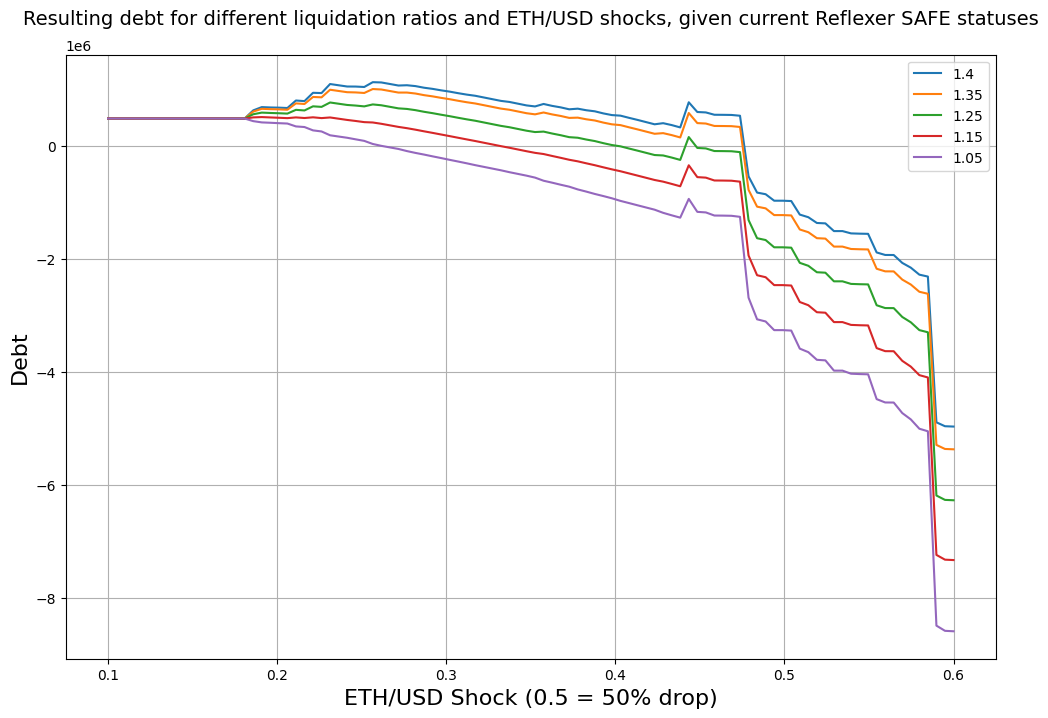

In [16]:
liq_ratios = [1.40, 1.35, 1.25, 1.15, 1.05]
all_shocks = np.linspace(0.1, 0.6, 100)

for lr in liq_ratios:    
    lr_shocks = []
    lr_surpluses = []
    for s in all_shocks:
        surplus = run(orig_safes, lr, s, initial_surplus=INITIAL_SURPLUS)
        lr_shocks.append(s)
        lr_surpluses.append(surplus)
    plt.plot(lr_shocks, lr_surpluses, label=lr)
    
plt.legend()
plt.title('Resulting debt for different liquidation ratios and ETH/USD shocks, given current Reflexer SAFE statuses\n', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Debt', fontsize=16)
plt.grid(True)
plt.show()

# Sim #1: Mainnet SAFE collateral amounts and stochastic c-ratios

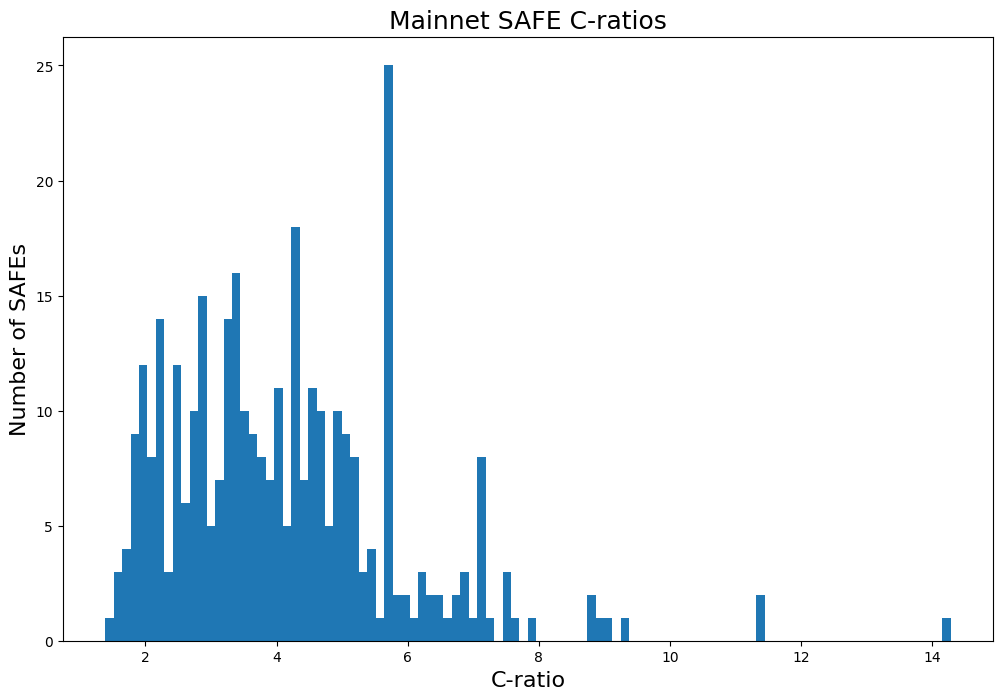

In [17]:
orig_safes = update_cratios(orig_safes, ETH_USD, REDEMPTION_PRICE)
orig_safes['cratio'].hist(bins=100)
plt.title('Mainnet SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.grid(False)
plt.show()

In [18]:
system_cratio = (orig_safes['collateral'].sum() * ETH_USD) / (orig_safes['debt'].sum() * REDEMPTION_PRICE)
print(f"Mainnet {system_cratio=:.2f}")

Mainnet system_cratio=3.02


### Fit many distributions to mainnnet c-ratios

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


,sumsquare_error,aic,bic,kl_div
chi,0.463525,927.418080,-2233.369457,inf
nakagami,0.463527,927.384438,-2233.368021,inf
mielke,0.465209,810.715304,-2226.301108,inf
burr,0.465209,810.714634,-2226.300718,inf
weibull_min,0.465388,867.120963,-2232.001916,inf


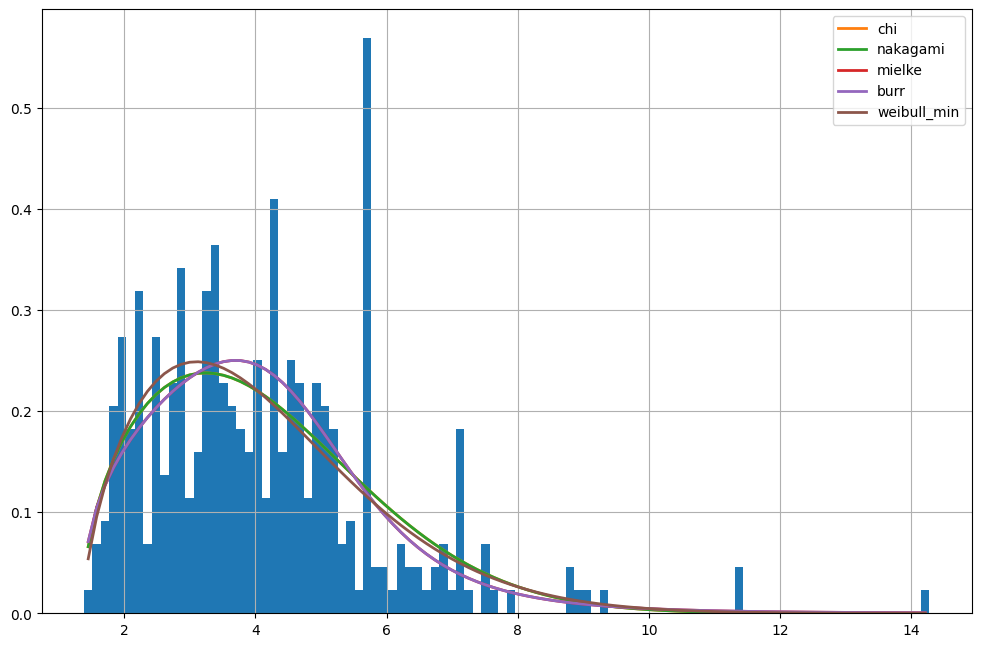

In [19]:
fitter_cratio = Fitter(orig_safes['cratio'].values)          
fitter_cratio.fit()
fitter_cratio.summary()

### Pick the best distribution and generate some c-ratios

In [20]:
# best_cratio = fitter_cratio.get_best(method = 'sumsquare_error')
cratio_params = fitter_cratio.fitted_param["mielke"]

/Users/georgekellerman/github/geb-data-science/venv/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


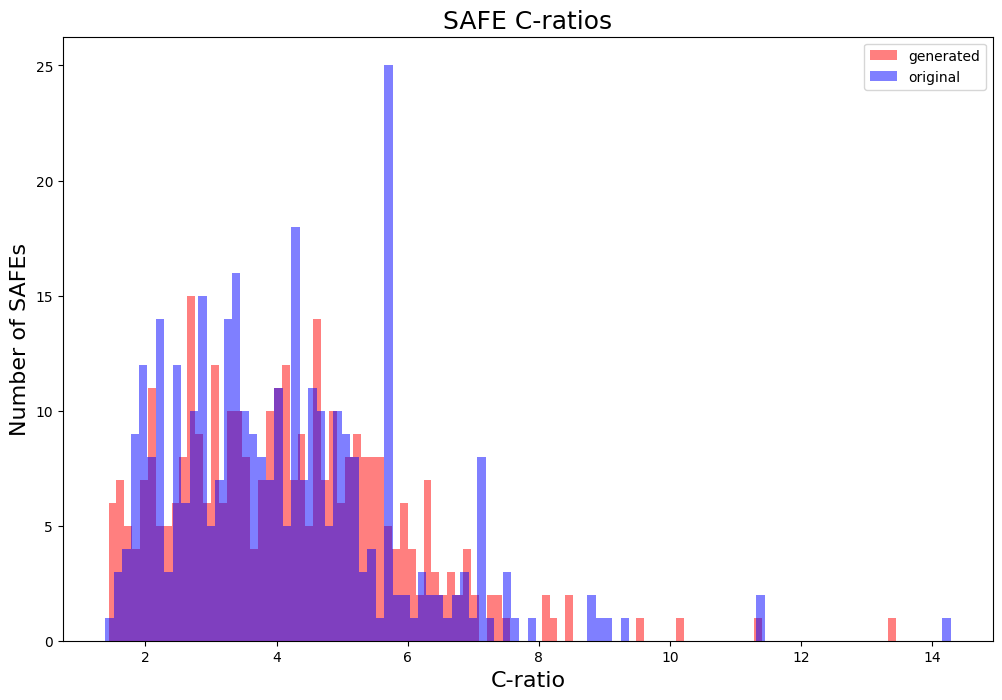

In [21]:
cratios_r = ss.mielke.rvs(*cratio_params, size=len(orig_safes)*2)
cratios_r = cratios_r[cratios_r > MAINNET_LIQ_RATIO]

df = pd.DataFrame(cratios_r, columns=['cratio'])
df = df.head(len(orig_safes))

df['cratio'].hist(bins=100, alpha=0.5, color='red', label='generated')

orig_safes['cratio'].hist(bins=100, color='blue', alpha=0.5, label='original')

plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Run Sim #1

In [ ]:
start = time.time()
all_shocks = []
all_surplus = []

min_shock = 0.00
max_shock = 0.6
shocks = np.linspace(min_shock, max_shock, 100)

for lr in LRS:
    for initial_surplus in [INITIAL_SURPLUS, 1E6]:
        for i in range(N_RUNS):
            cratios = ss.mielke.rvs(*cratio_params, size=len(orig_safes)*2)

            tmp_safes = pd.DataFrame(cratios, columns=['cratio'])   
            tmp_safes['cratio'] = tmp_safes[tmp_safes['cratio'] > MAINNET_LIQ_RATIO]   
            tmp_safes = tmp_safes.head(len(orig_safes))

            tmp_safes['collateral'] = orig_safes['collateral']

            tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
            
            # Consider debt ceiling, adding more possible debt
            added_debt = 0
            while added_debt < extra_debt:
                new_cr = ss.mielke.rvs(*cratio_params, size=1)[0]
                new_coll = tmp_safes['collateral'].sample().iloc[0]
                
                new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
                added_debt += new_debt
                tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
                
            assert added_debt == extra_debt
                
            lr_shocks = []
            lr_surpluses = []
            for s in shocks:
                surplus = run(tmp_safes, lr, s, initial_surplus)
                lr_shocks.append(s)
                lr_surpluses.append(surplus)
                all_shocks.append(s)
                all_surplus.append(surplus)
            
                       
            #plt.plot(lr_shocks, lr_surpluses, alpha=0.1)

        # plot mean
        df = pd.DataFrame({'shock': all_shocks,  'surplus': all_surplus})
        df_mean = df.groupby('shock').mean().reset_index()
        #plt.plot(df_mean['shock'], df_mean['surplus'])


        for PCT in PCTS:
            df_pct = df.groupby('shock').quantile(1.-PCT).reset_index()
            df_100 = df.groupby('shock').quantile(1.0).reset_index()
            
            """
            plt.plot(df_pct['shock'], df_pct['surplus'], ':')
            plt.plot(df_100['shock'], df_100['surplus'], ':')
            plt.fill_between(shocks, 
                            df_100['surplus'], 
                            df_pct['surplus'], alpha=0.4,label=f"{PCT*100}% confidence")
            """
            zero_pct = df_pct[df_pct['surplus'] > 0].sort_values('surplus')

            zero_debt_pct = zero_pct.iloc[0]['shock']
            print(f"{lr}, {initial_surplus}, {PCT}, {zero_debt_pct:.3f}")
        
        """
        plt.title(f'Stochastic c-ratios: {lr=}, {initial_surplus=}\n {N_RUNS=}', fontsize=14)
        plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
        plt.ylabel('Debt', fontsize=16)
        plt.grid(True)
        plt.legend()
        plt.show()
        """
print(f"{time.time() - start}")

1.2, 493000, 0.95, 0.255
1.2, 493000, 0.99, 0.133
1.2, 493000, 0.999, 0.000
1.2, 1000000.0, 0.95, 0.273
1.2, 1000000.0, 0.99, 0.152
1.2, 1000000.0, 0.999, 0.036
1.25, 493000, 0.95, 0.273
1.25, 493000, 0.99, 0.145
1.25, 493000, 0.999, 0.036


# Sim #2: Stochastic SAFE collateral amounts and stochastic c-ratios

### Fit many distributions to mainnnet collateral amounts

In [ ]:
fitter_coll = Fitter(np.log(orig_safes['collateral'].values))        
fitter_coll.fit()
fitter_coll.summary()

### Pick the best distribution and generate some collateral amounts

In [ ]:
#best_coll = fitter_coll.get_best(method = 'sumsquare_error')
coll_params = fitter_coll.fitted_param["skewcauchy"]

In [ ]:
colls_r = ss.skewcauchy.rvs(*coll_params, size=len(orig_safes)*2)

colls_r = np.exp(colls_r)

# Collateral

df = pd.DataFrame(colls_r, columns=['collateral'])
df = df[(df['collateral'] > 0) & (df['collateral'] < orig_safes['collateral'].max()) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
df = df.head(len(orig_safes))


#df['collateral'] *= orig_safes['collateral'].sum() / df['collateral'].sum()
df['collateral'].hist(bins=100, alpha=0.5, color='red', label='generated')

orig_safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
#plt.xlim([0, 1000])
plt.title('SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()


# Run Sim #2

In [ ]:
all_shocks = []
all_surplus = []

min_shock = 0.00
max_shock = 0.6
shocks = np.linspace(min_shock, max_shock, 100)

for lr in LRS:
    for initial_surplus in [INITIAL_SURPLUS, 1E6]:
        for i in range(N_RUNS):
            cratios = ss.mielke.rvs(*cratio_params, size=len(orig_safes)*2)
            #cratios = cratios[cratios > MAINNET_LIQ_RATIO]

            collaterals = ss.skewcauchy.rvs(*coll_params, size=len(orig_safes)*2)
            collaterals = np.exp(collaterals)


            tmp_safes = pd.DataFrame({'collateral': collaterals, 'cratio': cratios}) 
            tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['collateral'] < orig_safes['collateral'].max()) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
            tmp_safes = tmp_safes.head(len(orig_safes))

            assert len(tmp_safes) == len(orig_safes)
            # match sum of collateral to mainnet sum
            #tmp_safes['collateral'] *= orig_safes['collateral'].sum() / tmp_safes['collateral'].sum()

            tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
            
            # Consider debt ceiling, adding more possible debt           
            added_debt = 0
            while added_debt < extra_debt:
                # Sample c-ratios and collateral amounts
                new_cr = ss.mielke.rvs(*cratio_params, size=1)[0]
                while new_cr < MAINNET_LIQ_RATIO: 
                    new_cr = ss.mielke.rvs(*cratio_params, size=1)[0]
                    
                new_coll = np.exp(ss.skewcauchy.rvs(*coll_params, size=1))[0]
                 
                # calculate debt
                new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
                added_debt += new_debt
                
                # Add new SAFE
                tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
                
            assert added_debt == extra_debt
                     
            lr_shocks = []
            lr_surpluses = []
            for s in shocks:
                surplus = run(tmp_safes, lr, s, initial_surplus)
                lr_shocks.append(s)
                lr_surpluses.append(surplus)
                all_shocks.append(s)
                all_surplus.append(surplus)
                   
            #plt.plot(shocks, results, alpha=0.1)

        # plot mean
        df = pd.DataFrame({'shock': all_shocks,  'surplus': all_surplus})
        df_mean = df.groupby('shock').mean().reset_index()
        #plt.plot(df_mean['shock'], df_mean['surplus'])

        for PCT in PCTS:
            df_pct = df.groupby('shock').quantile(1. - PCT).reset_index()
            df_100 = df.groupby('shock').quantile(1.0).reset_index()
            
            """
            plt.plot(df_pct['shock'], df_pct['surplus'], ':')
            plt.plot(df_100['shock'], df_100['surplus'], ':')
            plt.fill_between(shocks, 
                            df_100['surplus'], 
                            df_pct['surplus'], alpha=0.4,label=f"{PCT*100}% confidence")
            """
            zero_pct = df_pct[df_pct['surplus'] > 0].sort_values('surplus')

            zero_debt_pct = zero_pct.iloc[0]['shock']
            print(f"{lr}, {initial_surplus}, {PCT}, {zero_debt_pct:.3f}")
        
        """
        plt.title(f'Stochastic collateral amounts and c-ratios: {lr=}, {initial_surplus=}\n {N_RUNS=}', fontsize=14)
        plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
        plt.ylabel('Debt', fontsize=16)
        plt.grid(True)
        plt.legend()
        plt.show()
        """

# Sim #3: Gaussian Mixture Model for SAFE collateral amounts and c-ratios

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# Create a Gaussian Mixture Model with one component
clf = mixture.GaussianMixture(n_components=1, covariance_type='full')

safes = orig_safes.copy()

# Transform collateral to make it normal
#pt = PowerTransformer()
#safes['collateral'] = pt.fit_transform(safes['collateral'].values.reshape(-1,1))
safes['collateral'] = np.log(safes['collateral'])

"""
safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
plt.title('Transformed collateral')
plt.legend()
plt.grid(False)
plt.show()
"""

# Fit
clf.fit(safes[['collateral', 'cratio']])

# display predicted scores by the model as a contour plot
x = np.linspace(0, 50.)
y = np.linspace(0, 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(safes['collateral'], safes['cratio'], .8, color='blue')

#plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.xlabel('Log Collateral', fontsize=16)
plt.ylabel('C-ratio', fontsize=16)
plt.show()


In [ ]:
# C-ratios
sample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(orig_safes)*2)
df = pd.DataFrame(sample, columns=['collateral', 'cratio'])
df = df[df['cratio'] > MAINNET_LIQ_RATIO]

df['cratio'].hist(bins=100, alpha=0.5, color='red', label='generated')

orig_safes['cratio'].hist(bins=100, color='blue', alpha=0.5, label='original')

plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Collateral
sample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(orig_safes)*2)
df = pd.DataFrame(sample, columns=['collateral', 'cratio'])
df = df[df['cratio'] > MAINNET_LIQ_RATIO]
df = df.head(len(orig_safes))

df['collateral'] = np.exp(df['collateral'])

#df['collateral'] = pt.inverse_transform(df['collateral'].values.reshape(-1,1))

df['collateral'] *= orig_safes['collateral'].sum() / df['collateral'].sum()
df['collateral'].hist(bins=1000, alpha=0.5, color='red', label='generated')

orig_safes['collateral'].hist(bins=1000, color='blue', alpha=0.5, label='original')
plt.xlim([0, 1000])
plt.title('SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Run Sim #3

In [ ]:
all_shocks = []
all_surplus = []

min_shock = 0.00
max_shock = 0.6
shocks = np.linspace(min_shock, max_shock, 100)
for lr in LRS:
    for initial_surplus in [INITIAL_SURPLUS, 1E6]:
        for i in range(N_RUNS):
            gaussian_safes = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(orig_safes)*2)

            tmp_safes = pd.DataFrame(gaussian_safes, columns=['collateral', 'cratio'])

            tmp_safes['collateral'] = np.exp(tmp_safes['collateral'])
            #tmp_safes['collateral'] = pt.inverse_transform(tmp_safes['collateral'].values.reshape(-1,1))

            tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
            tmp_safes = tmp_safes.head(len(orig_safes))

            # match sum of collateral to mainnet sum
            #tmp_safes['collateral'] *= orig_safes['collateral'].sum() / tmp_safes['collateral'].sum()

            tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
            
            # Consider debt ceiling, adding more possible debt
            # Sample SAFEs
            gaussian_safes = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], 1000)
            new_safes = pd.DataFrame(gaussian_safes, columns=['collateral', 'cratio'])
            new_safes['collateral'] = np.exp(new_safes['collateral'])
            
            # Filter out acceptable samples
            new_safes = new_safes[(new_safes['collateral'] > 0) & (new_safes['cratio'] > MAINNET_LIQ_RATIO)]

            # Calculate debt
            new_safes['debt'] = new_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / new_safes['cratio'] 
            
            # Only use enough SAFEs to fill `extra_debt`
            new_safes['total_debt'] = new_safes['debt'].cumsum()        
            final_safes = new_safes[new_safes['total_debt'] <= extra_debt]
 
            final_safes.drop('total_debt', axis='columns')
            tmp_safes = pd.concat([tmp_safes, final_safes])   

            
            lr_shocks = []
            lr_surpluses = []
            for s in shocks:
                surplus = run(tmp_safes, lr, s, initial_surplus)
                if s == 0.0 and surplus < 0:
                    print("negative surplus at zero shock")
                    tmp_safes.to_csv('tmp_safes.csv')
                lr_shocks.append(s)
                lr_surpluses.append(surplus)
                all_shocks.append(s)
                all_surplus.append(surplus)
            
            #plt.plot(shocks, results, alpha=0.1)

        # plot mean
        df = pd.DataFrame({'shock': all_shocks,  'surplus': all_surplus})
        df_mean = df.groupby('shock').mean().reset_index()
        #plt.plot(df_mean['shock'], df_mean['surplus'])

        for PCT in PCTS:
            df_pct = df.groupby('shock').quantile(1.-PCT).reset_index()
            df_100 = df.groupby('shock').quantile(1.0).reset_index()
            """
            plt.plot(df_pct['shock'], df_pct['surplus'], ':')
            plt.plot(df_100['shock'], df_100['surplus'], ':')
            plt.fill_between(shocks, 
                            df_100['surplus'], 
                            df_pct['surplus'], alpha=0.4,label=f"{PCT*100}% confidence")
            """
            zero_pct = df_pct[df_pct['surplus'] > 0].sort_values('surplus')

            zero_debt_pct = zero_pct.iloc[0]['shock']
            print(f"{lr}, {initial_surplus}, {PCT}, {zero_debt_pct:.3f}")
        
        """
        plt.title(f'GMM collateral amounts and c-ratios: {lr=}, {initial_surplus=}\n {N_RUNS=}', fontsize=14)
        plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
        plt.ylabel('Debt', fontsize=16)
        plt.grid(True)
        plt.legend()
        plt.ylim([-1E7,2E6])
        plt.show()
        """

# Results: Shocks where upper 95th percentile of surplus is greater than 0


| Liquidation Ratio| Initial Surplus |    Sim #1   |     Sim #2   |    Sim #3   |
| ---------------- | --------------- |-------------|--------------|-------------|
| 1.20             | INITIAL_SURPLUS |    0.363    |     0.322    |     0.317   |
| 1.20             | 1E6             |    0.373    |     0.332    |     0.337   |
| 1.25             | INITIAL_SURPLUS |    0.378    |     0.337    |     0.337   |
| 1.25             | 1E6             |    0.388    |     0.342    |     0.353   |
| 1.30             | INITIAL_SURPLUS |    0.408    |     0.353    |     0.368   |
| 1.30             | 1E6             |    0.418    |     0.358    |     0.493   |
| 1.35             | INITIAL_SURPLUS |    0.413    |     0.358    |     0.418   |
| 1.35             | 1E6             |    0.428    |     0.363    |     0.433   |
| 1.40             | INITIAL_SURPLUS |    0.428    |     0.368    |     0.433   |
| 1.40             | 1E6             |    0.438    |     0.373    |     0.438   |